In [1]:
import scanpy as sc
import numpy as np
import warnings
warnings.filterwarnings("ignore")

from scimilarity.utils import lognorm_counts, align_dataset
from scimilarity import CellEmbedding
import os
random_seed = 42
np.random.seed(random_seed)

ground_truth_key = 'cell2'

In [3]:
data_path = "/home/nicolas/Documents/Foundational_models/data_with_scimilarity.h5ad"
data = sc.read(data_path)
print(f"Data: {data}")

Data: AnnData object with n_obs × n_vars = 36763 × 25139
    obs: 'cell1', 'cell2', 'fraction', 'sample', 'cell_ID', 'n_genes', 'leiden'
    var: 'hgnc_symbol', 'ensembl_gene_id', 'gene_biotype', 'n_cells', 'mean', 'std'
    uns: 'leiden', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_scimilarity', 'X_umap'
    varm: 'PCs'
    layers: 'RNA', 'log1p_norm'
    obsp: 'connectivities', 'distances'


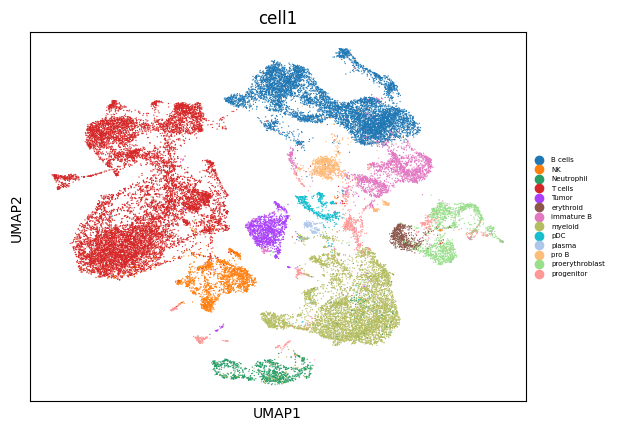

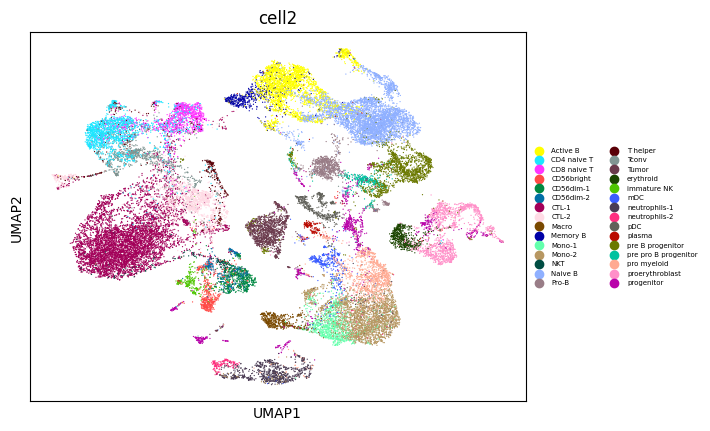

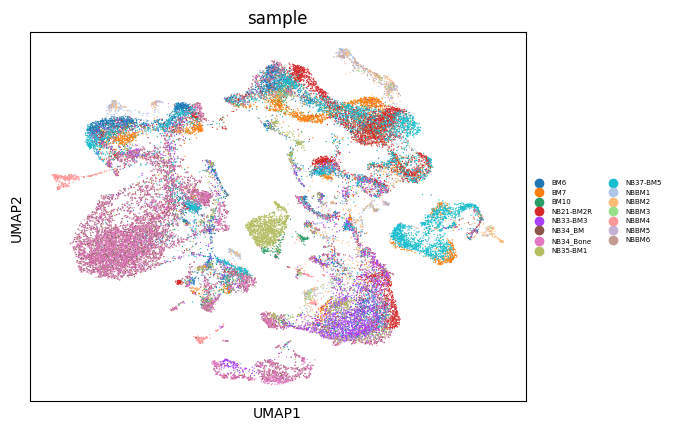

In [7]:

sc.pp.neighbors(data, use_rep="X_scimilarity")
sc.tl.umap(data)

for feature in ["cell1", "cell2", "fraction", "sample"]:
    sc.pl.umap(data, color=feature, legend_fontsize=5)

Fitting GMM with 13 components...
Calculating entropy...
Added 'GMM_probabilities' to data.obsm
Added 'GMM_entropy' to data.obs
Added 'GMM_cluster' (dominant cluster) to data.obs

Done with GMM and entropy calculation.

--- Starting Visualization (using embedding: 'X_umap') ---
Plotting dominant GMM clusters on X_umap...


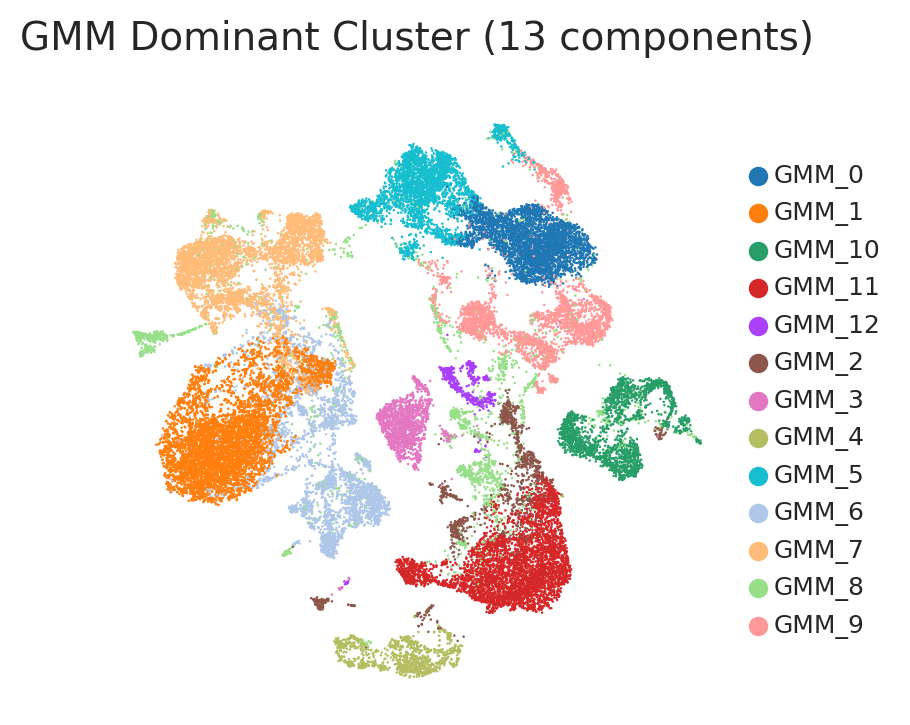

Plotting GMM entropy on X_umap...


Plotting clusters and entropy side-by-side on X_umap...


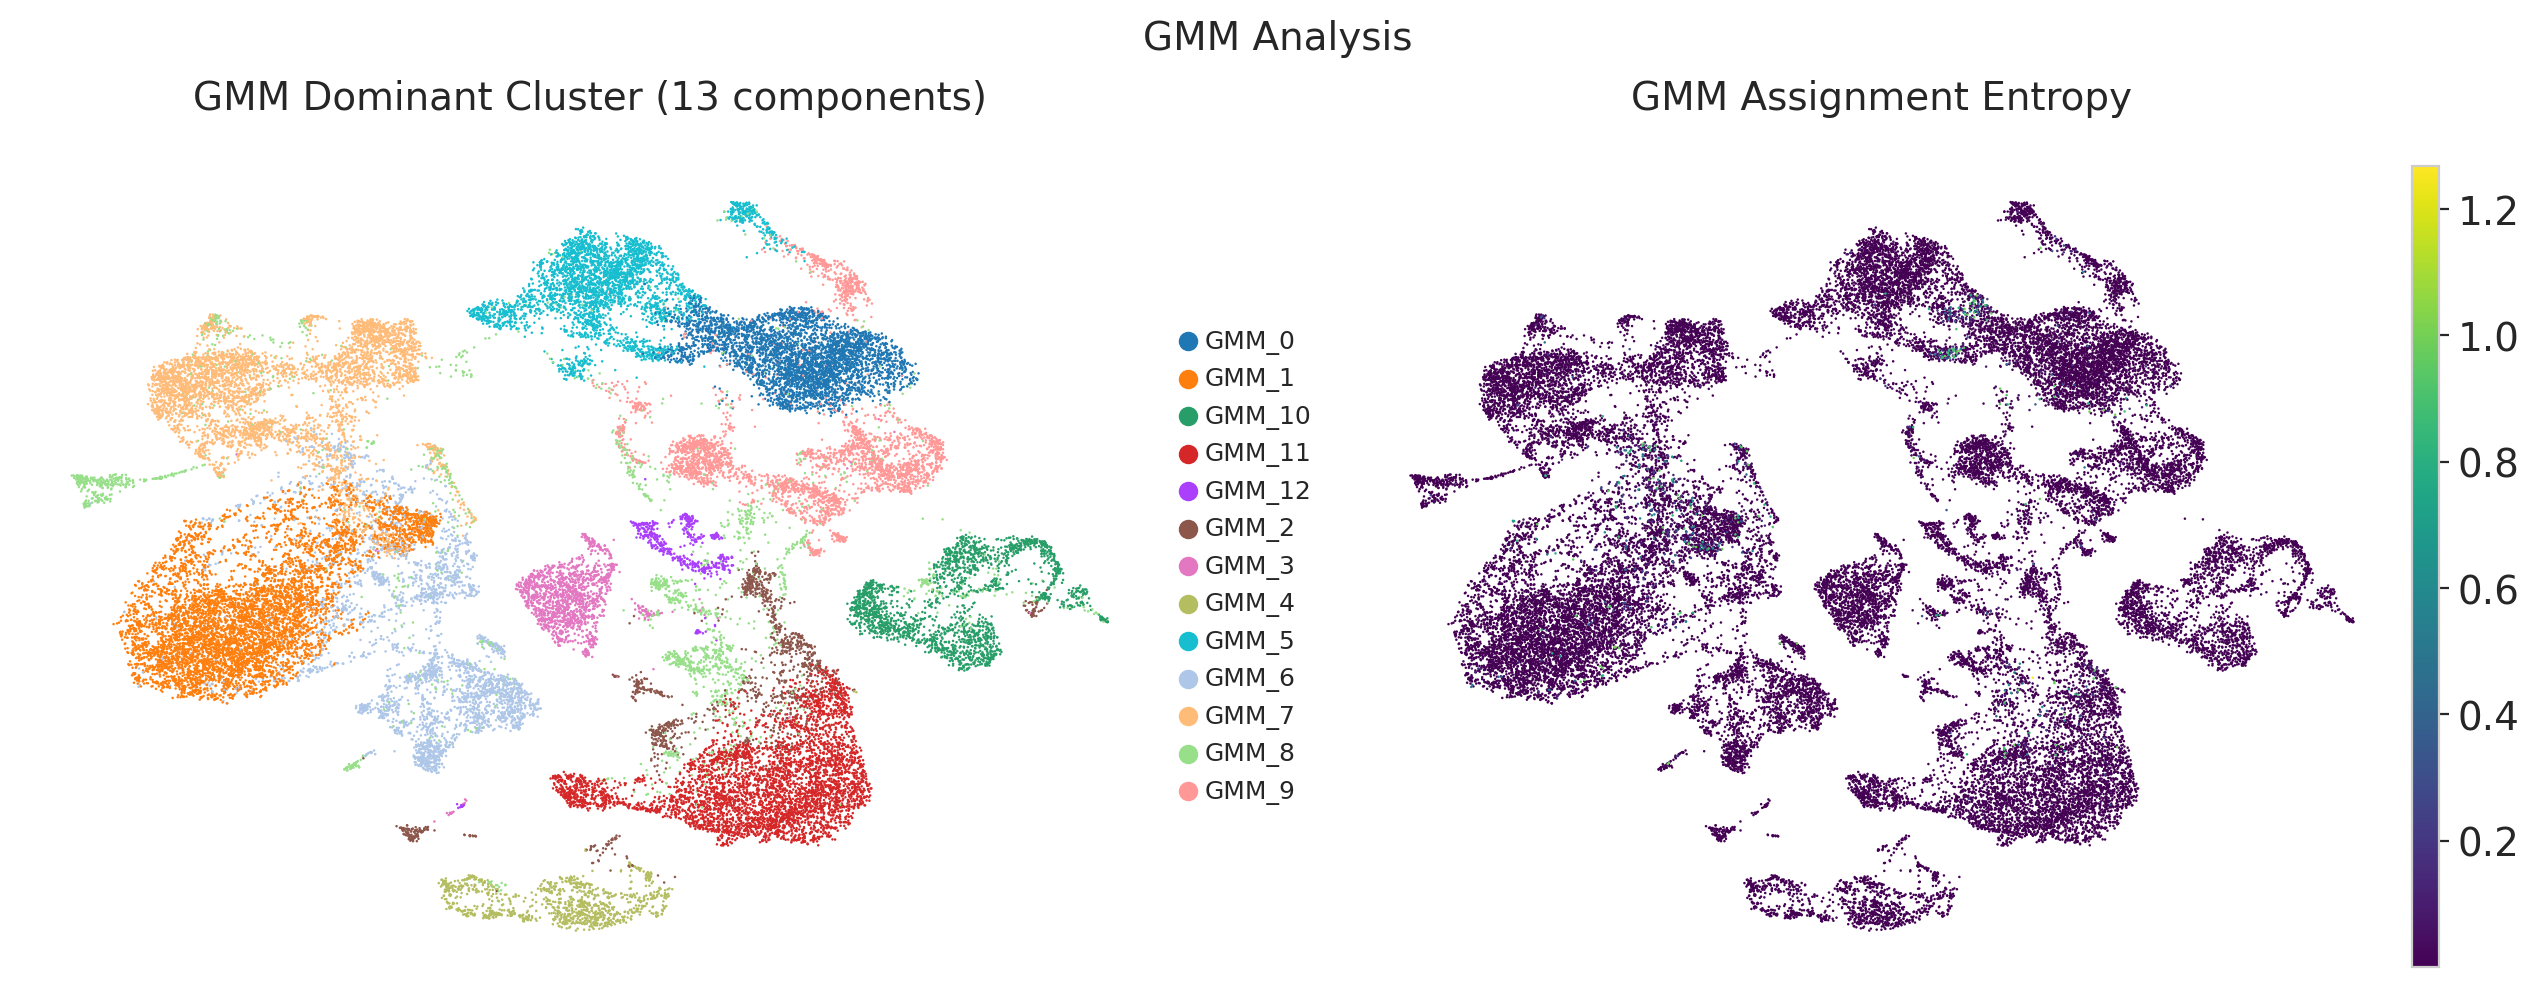

<Axes: title={'center': 'cell2'}, xlabel='X_umap1', ylabel='X_umap2'>

In [10]:
# --- GMM Soft Clustering and Entropy Calculation ---
from sklearn.mixture import GaussianMixture
from scipy.stats import entropy
import numpy as np
import matplotlib.pyplot as plt  # <<< ENSURE THIS IS IMPORTED
import seaborn as sns 

n_clusters = 13  # Specify the desired number of clusters (components) - adjust as needed


embeddings = data.obsm['X_scimilarity']
print(f"Fitting GMM with {n_clusters} components...")
gmm = GaussianMixture(n_components=n_clusters,
                      random_state=random_seed,
                      covariance_type='full') # 'full' is default, other options: 'tied', 'diag', 'spherical'
gmm.fit(embeddings)


gmm_probabilities = gmm.predict_proba(embeddings)
print("Calculating entropy...")
# Entropy H(p) = - sum(p_i * log2(p_i))
# Add a small epsilon to avoid log(0)
epsilon = 1e-9
cell_entropy = entropy(gmm_probabilities.T + epsilon, base=2)

# 6. Store results in AnnData object
data.obsm['GMM_probabilities'] = gmm_probabilities
print("Added 'GMM_probabilities' to data.obsm")
data.obs['GMM_entropy'] = cell_entropy
print("Added 'GMM_entropy' to data.obs")

# --- Add Dominant Cluster Assignment ---
# Find the cluster index with the highest probability for each cell
dominant_cluster = np.argmax(gmm_probabilities, axis=1)
# Store as categorical strings for better plotting with scanpy
data.obs['GMM_cluster'] = [f'GMM_{c}' for c in dominant_cluster]
data.obs['GMM_cluster'] = data.obs['GMM_cluster'].astype('category')
print("Added 'GMM_cluster' (dominant cluster) to data.obs")

print("\nDone with GMM and entropy calculation.")

embedding_key = 'X_umap'
# --- Visualization ---
print(f"\n--- Starting Visualization (using embedding: '{embedding_key}') ---")


sc.settings.set_figure_params(dpi=100, facecolor='white', frameon=False)
sns.set_style("whitegrid") # Or "white", "ticks", etc.

# --- Titles ---
title_cluster = f'GMM Dominant Cluster ({n_clusters} components)'
title_entropy = 'GMM Assignment Entropy'
title_y_position = 1.05 # Adjust this value to move title further up (e.g., 1.05) or down (e.g., 1.01)

# 1. Visualize Dominant GMM Clusters
print(f"Plotting dominant GMM clusters on {embedding_key}...")
fig1, ax1 = plt.subplots()
sc.pl.embedding(data,
                basis=embedding_key,
                color='GMM_cluster',
                legend_loc='right margin',
                legend_fontsize=9,
                ax=ax1,
                show=False)

# Set title manually using matplotlib with adjusted vertical position
ax1.set_title(title_cluster, y=title_y_position)
# plt.savefig(f'gmm_clusters_{embedding_key}.png', dpi=output_fig_dpi, bbox_inches='tight')
plt.show()

# 2. Visualize GMM Assignment Entropy
print(f"Plotting GMM entropy on {embedding_key}...")
fig2, ax2 = plt.subplots()
sc.pl.embedding(data,
                basis=embedding_key,
                color='GMM_entropy',

                cmap='viridis',
                colorbar_loc='right',
                ax=ax2,
                show=False)
# Set title manually using matplotlib with adjusted vertical position
ax2.set_title(title_entropy, y=title_y_position)
# plt.savefig(f'gmm_entropy_{embedding_key}.png', dpi=output_fig_dpi, bbox_inches='tight')
plt.show()

# 3. Visualize Both Side-by-Side 
print(f"Plotting clusters and entropy side-by-side on {embedding_key}...")
fig3, axes = plt.subplots(1, 2, figsize=(13, 5))

# Plot Clusters on the left
sc.pl.embedding(data,
                basis=embedding_key,
                color='GMM_cluster',
                title=None, # Remove title from scanpy call
                legend_loc='right margin',
                legend_fontsize=9,
                ax=axes[0],
                show=False)
axes[0].set_title(title_cluster, y=title_y_position) # Set title manually
axes[0].set_xlabel(f"{embedding_key.split('_')[-1].upper()} 1")
axes[0].set_ylabel(f"{embedding_key.split('_')[-1].upper()} 2")

# Plot Entropy on the right
sc.pl.embedding(data,
                basis=embedding_key,
                color='GMM_entropy',
                title=None, # Remove title from scanpy call
                cmap='viridis',
                colorbar_loc='right',
                ax=axes[1],
                show=False)

axes[1].set_title(title_entropy, y=title_y_position) # Set title manually
axes[1].set_xlabel(f"{embedding_key.split('_')[-1].upper()} 1")
axes[1].set_ylabel(f"{embedding_key.split('_')[-1].upper()} 2")


# Use tight_layout *after* setting titles
plt.tight_layout(rect=[0, 0, 1, 0.97]) # Add rect to potentially leave space for suptitle if needed, adjust top value (0.97) if titles still overlap
fig3.suptitle("GMM Analysis", fontsize=14, y=0.99) # Example suptitle

# plt.savefig(f'gmm_clusters_entropy_{embedding_key}_combined.png', dpi=output_fig_dpi, bbox_inches='tight')
plt.show()
sc.pl.embedding(data,
                basis=embedding_key,
                color=ground_truth_key,
                legend_loc='right margin',
                legend_fontsize=9,
                ax=ax1,
                show=False)

In [14]:
# --- 3a: K-Means Clustering ---
# Decide on the number of clusters for k-means.
import pandas as pd
from sklearn.cluster import KMeans

n_clusters_kmeans = n_clusters 
print(f"Running K-Means with {n_clusters_kmeans} clusters on embeddings...")
kmeans = KMeans(n_clusters=n_clusters_kmeans, random_state=random_seed, n_init=10)
kmeans_labels = kmeans.fit_predict(embeddings)
data.obs['kmeans'] = pd.Categorical([f'KMeans_{c}' for c in kmeans_labels])
print(f"Stored K-Means results in embed_adata.obs['kmeans']")


# --- 3b: Louvain Clustering ---
# Louvain uses the neighbors graph computed earlier
# Resolution parameter influences the number of clusters found. Tune as needed.
print("Running Louvain clustering...")
sc.tl.louvain(data, random_state=random_seed, key_added='louvain') # Default resolution=1.0
print(f"Stored Louvain results in embed_adata.obs['louvain']")
# Visualize number of clusters found
print(f"Found {len(data.obs['louvain'].cat.categories)} Louvain clusters.")

# --- 3c: Leiden Clustering ---
# Leiden also uses the neighbors graph and is generally preferred over Louvain
print("Running Leiden clustering...")
sc.tl.leiden(data, random_state=random_seed, key_added='leiden') # Default resolution=1.0
print(f"Stored Leiden results in embed_adata.obs['leiden']")
# Visualize number of clusters found
print(f"Found {len(data.obs['leiden'].cat.categories)} Leiden clusters.")

Running K-Means with 13 clusters on embeddings...
Stored K-Means results in embed_adata.obs['kmeans']
Running Louvain clustering...
Stored Louvain results in embed_adata.obs['louvain']
Found 34 Louvain clusters.
Running Leiden clustering...
Stored Leiden results in embed_adata.obs['leiden']
Found 43 Leiden clusters.



--- Starting Evaluation Against Known Cell Labels ---

Index(['cell1', 'cell2', 'fraction', 'sample', 'cell_ID', 'n_genes', 'leiden',
       'GMM_entropy', 'GMM_cluster', 'kmeans', 'louvain'],
      dtype='object')

--- 1. Clustering Evaluation Metrics (vs 'cell2') ---

Evaluating: GMM_cluster
  Adjusted Rand Index (ARI): 0.5610
  Normalized Mutual Info (NMI): 0.6928
  Homogeneity: 0.6247
  Completeness: 0.7776
  V-Measure: 0.6928

Evaluating: kmeans
  Adjusted Rand Index (ARI): 0.6150
  Normalized Mutual Info (NMI): 0.7265
  Homogeneity: 0.6516
  Completeness: 0.8210
  V-Measure: 0.7265

Evaluating: louvain
  Adjusted Rand Index (ARI): 0.6011
  Normalized Mutual Info (NMI): 0.7361
  Homogeneity: 0.7575
  Completeness: 0.7159
  V-Measure: 0.7361

Evaluating: leiden
  Adjusted Rand Index (ARI): 0.4996
  Normalized Mutual Info (NMI): 0.7166
  Homogeneity: 0.7726
  Completeness: 0.6681
  V-Measure: 0.7166

--- Metrics Summary ---
                  ARI       NMI  Homogeneity  Completeness

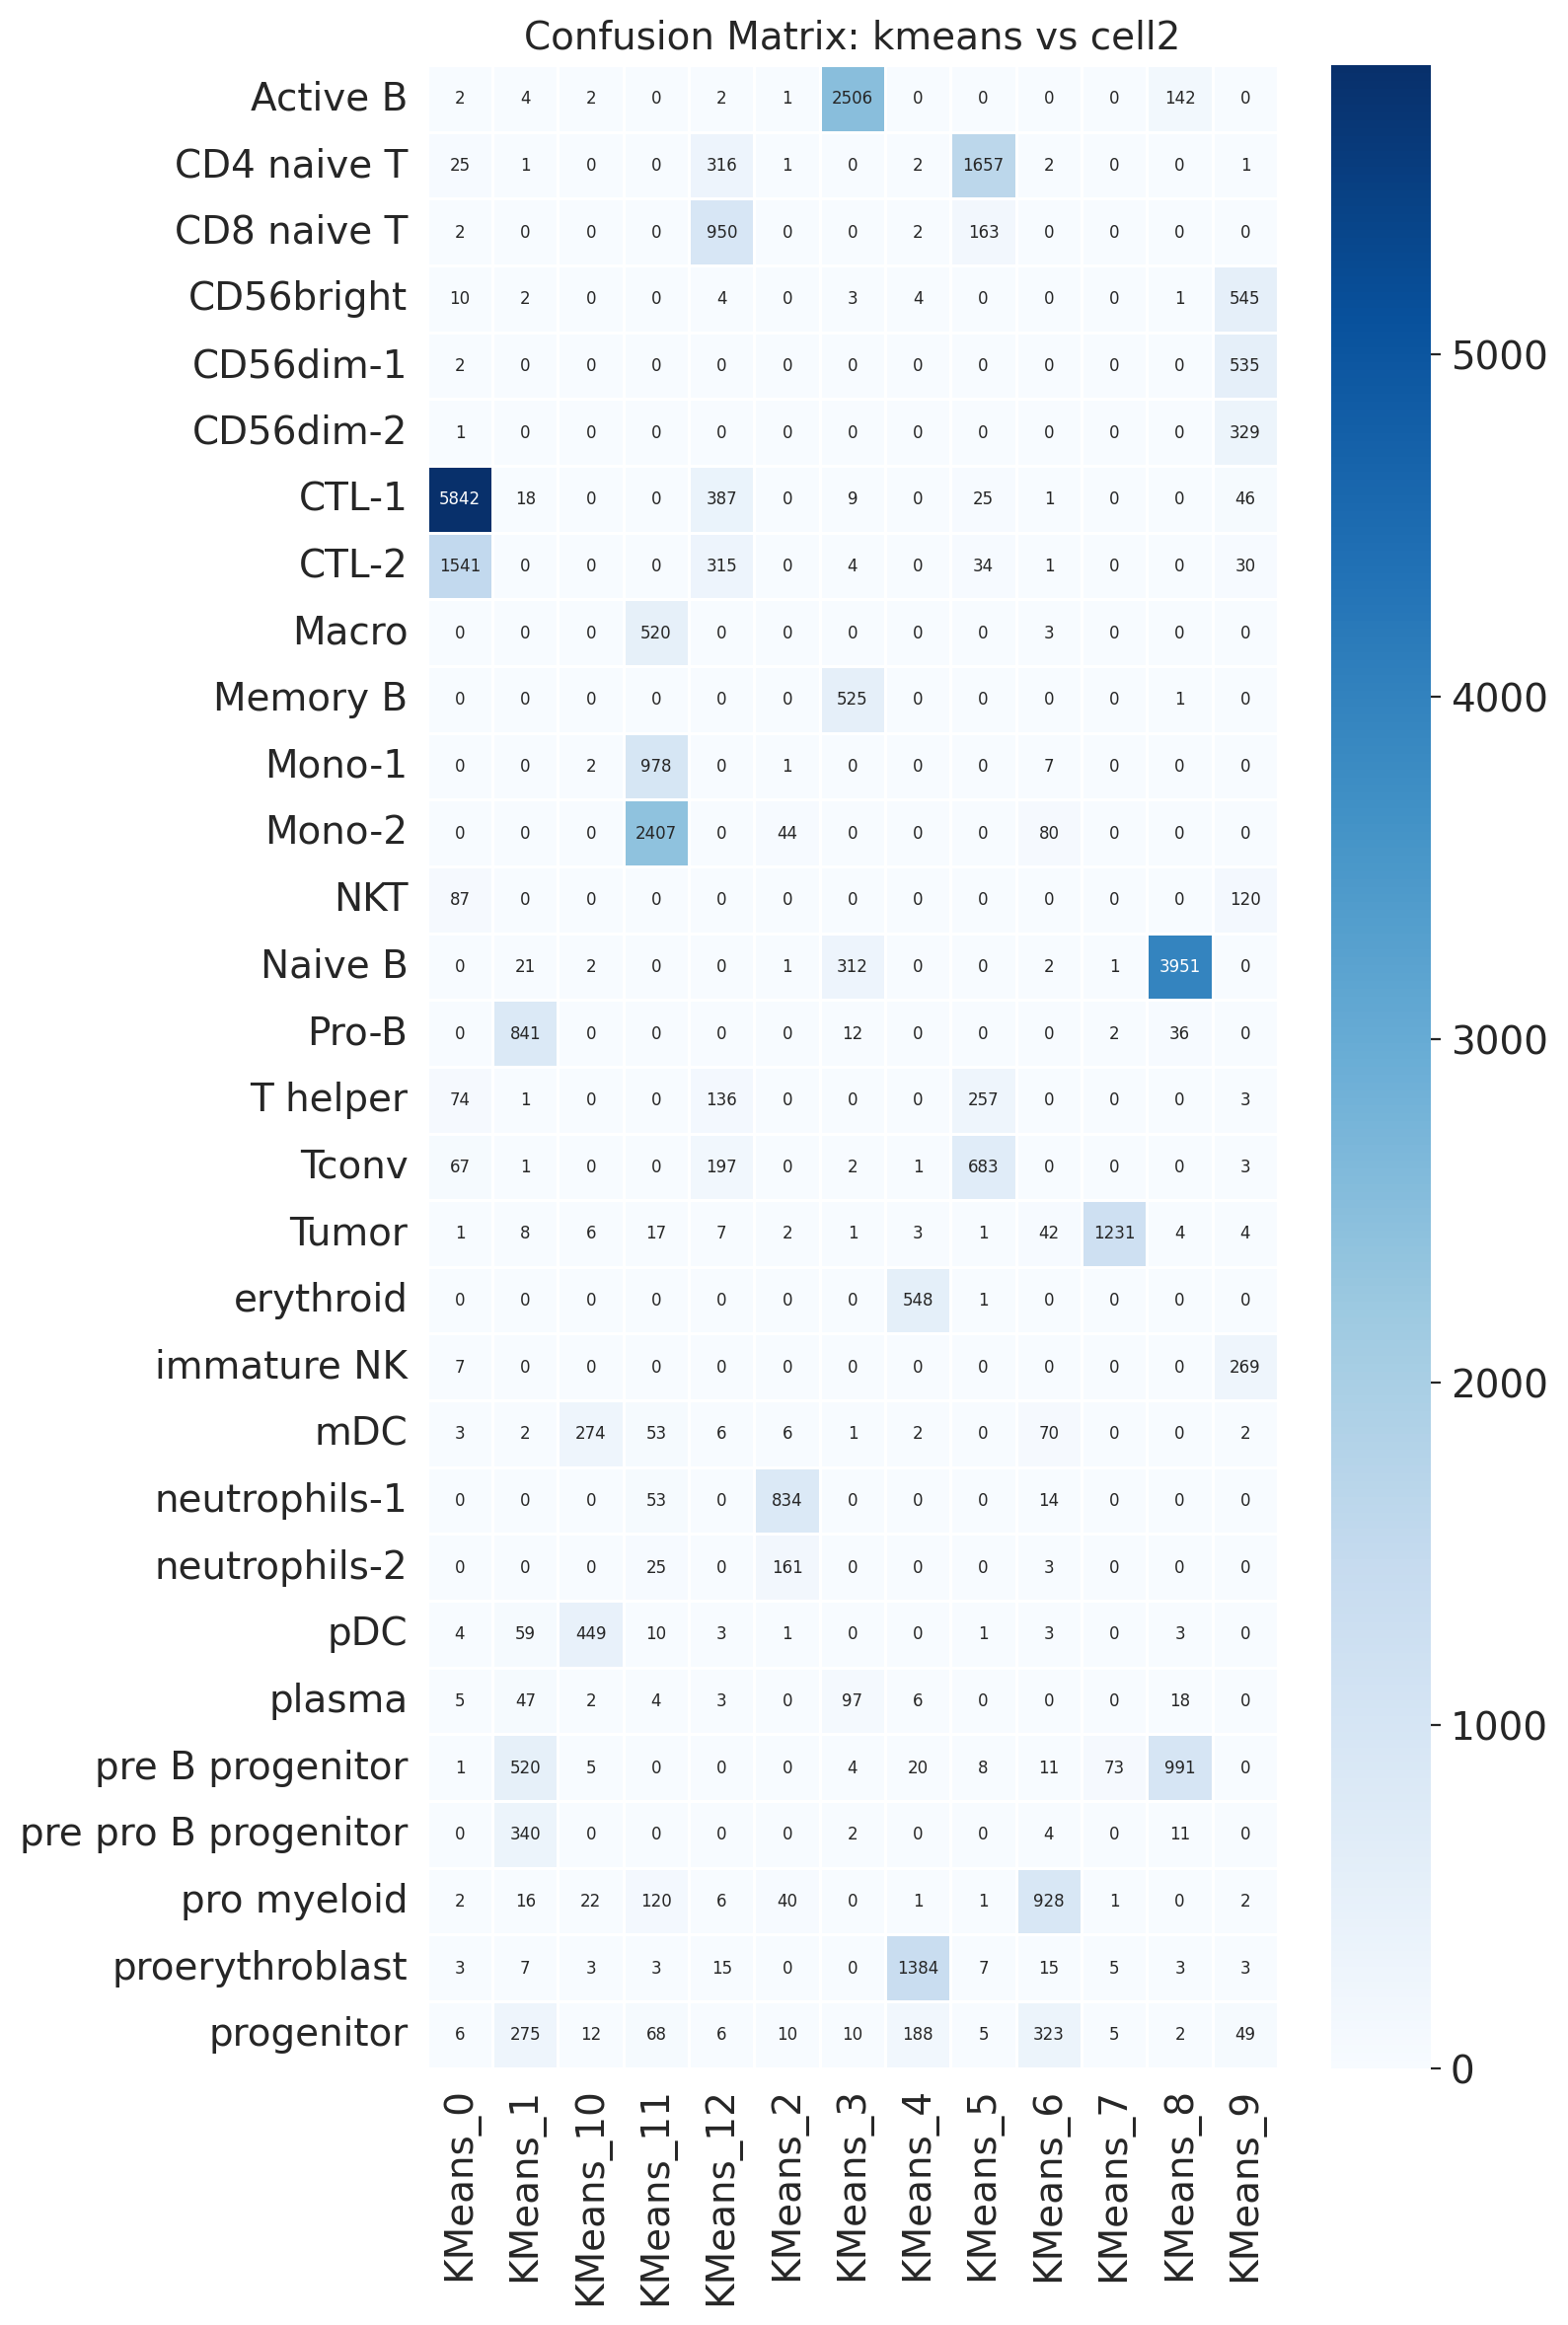


--- 3. Cluster Composition Bar Plots ---

Generating Composition Plot for: GMM_cluster



Generating Composition Plot for: kmeans


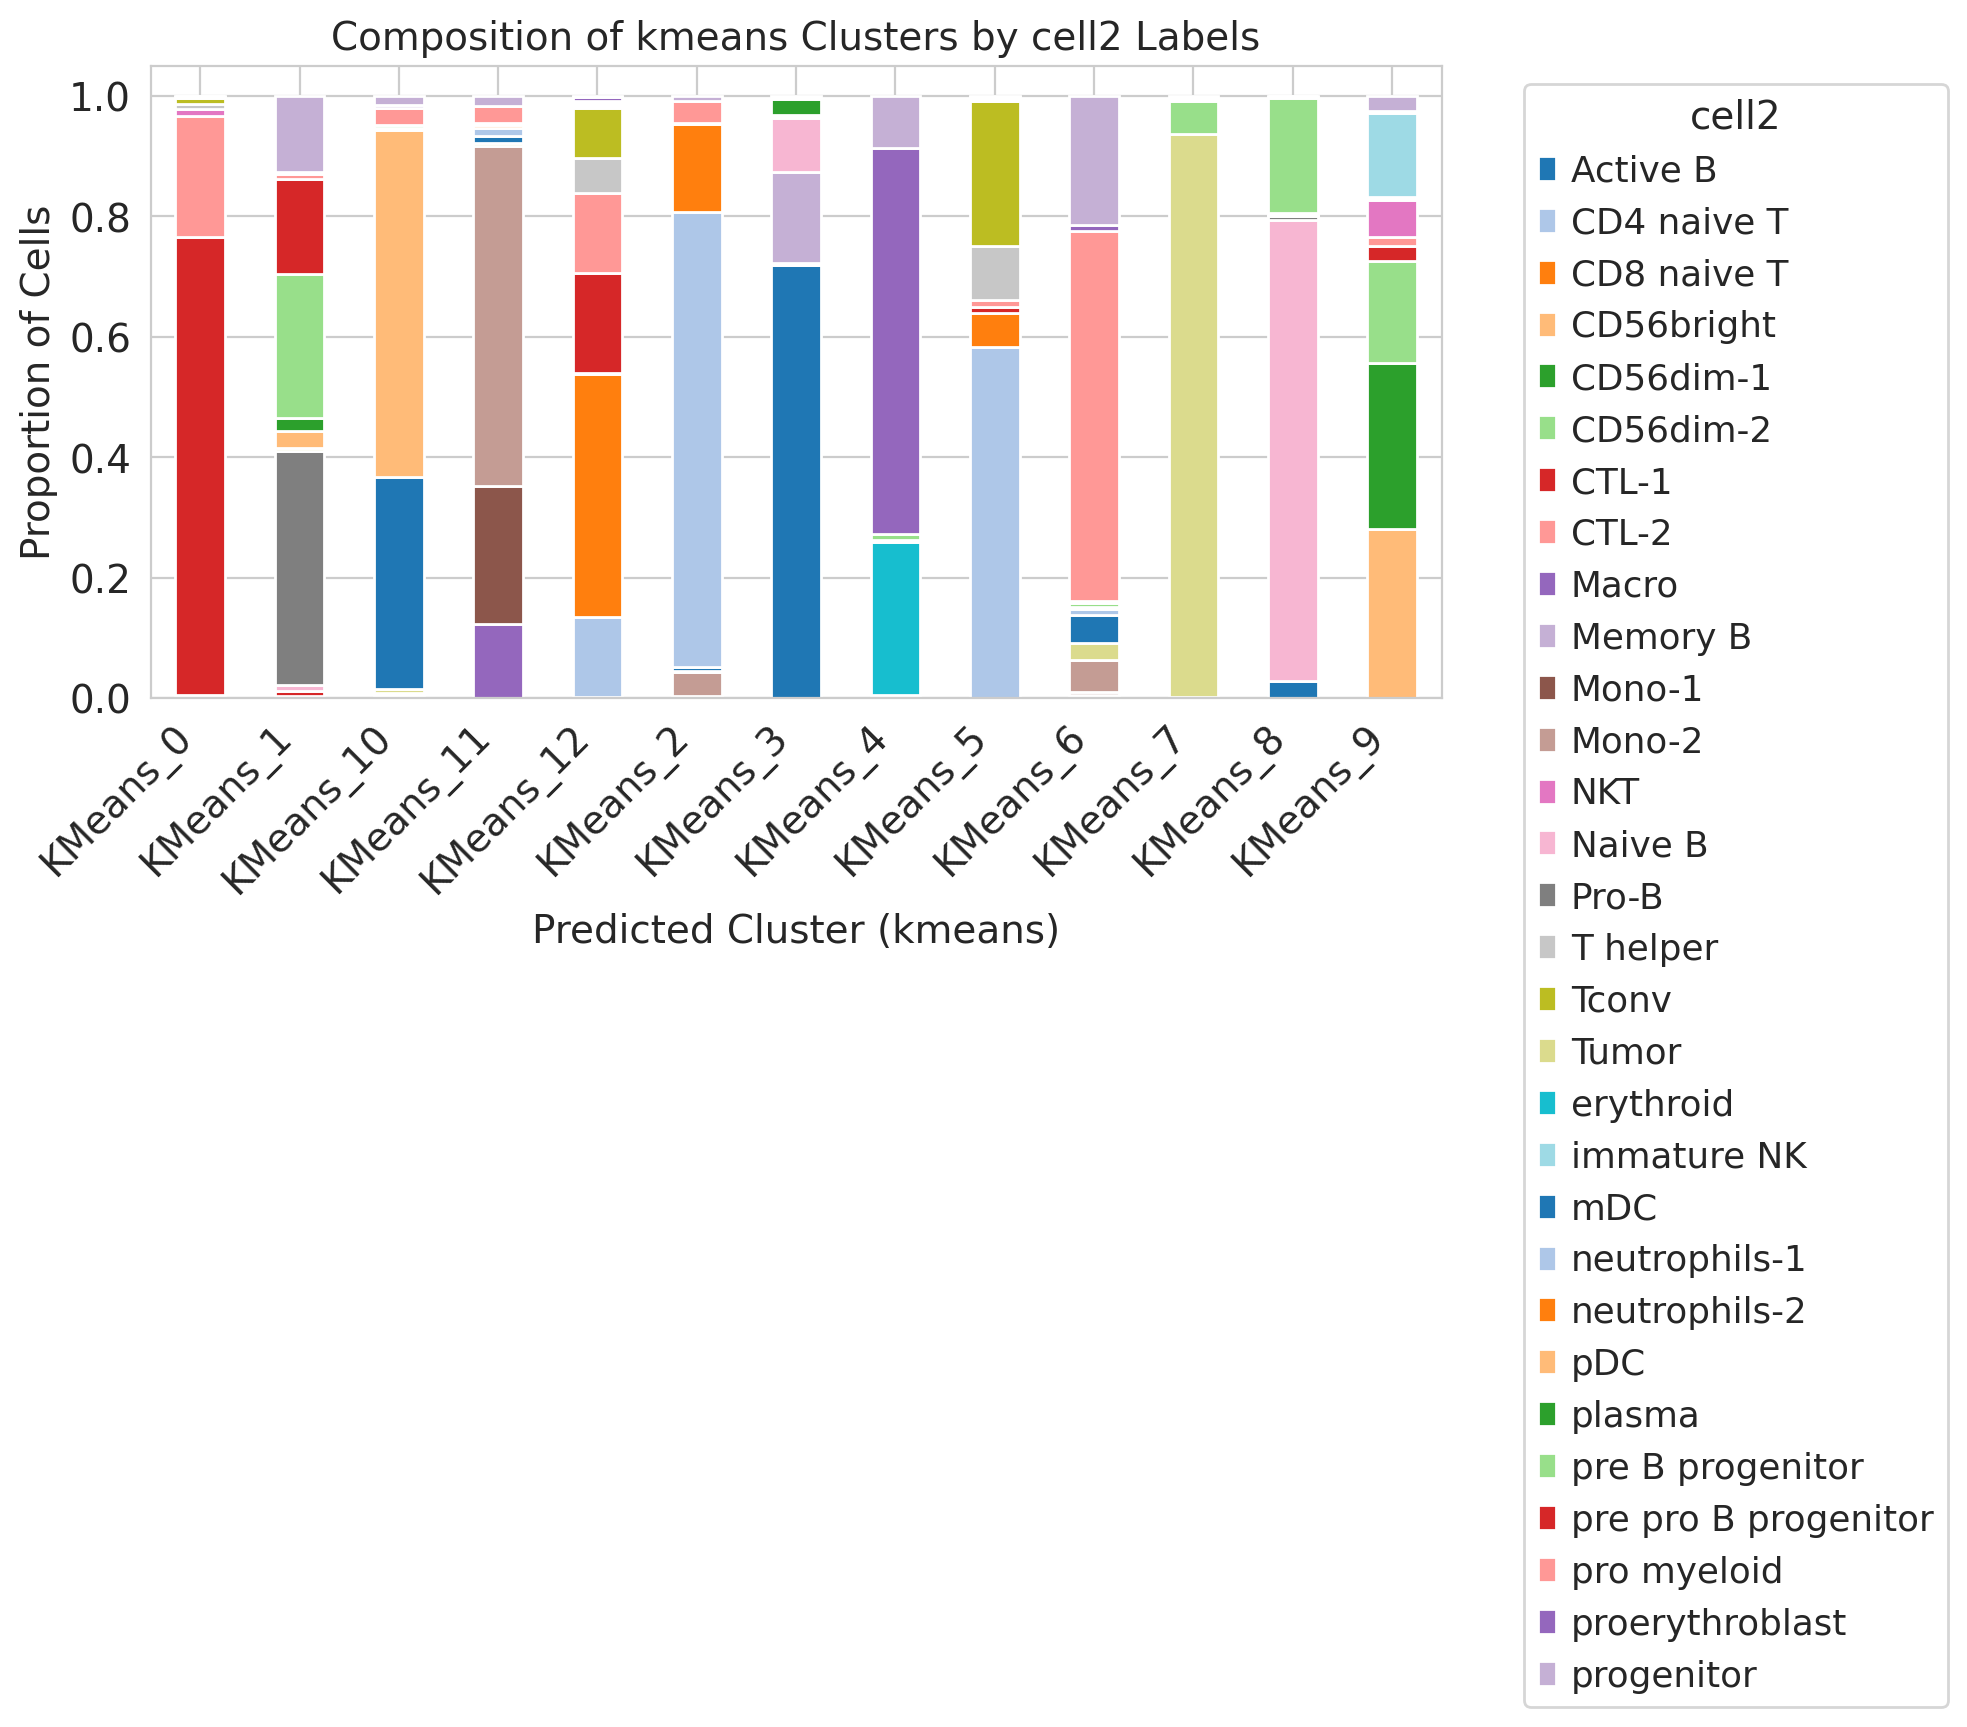


Generating Composition Plot for: louvain


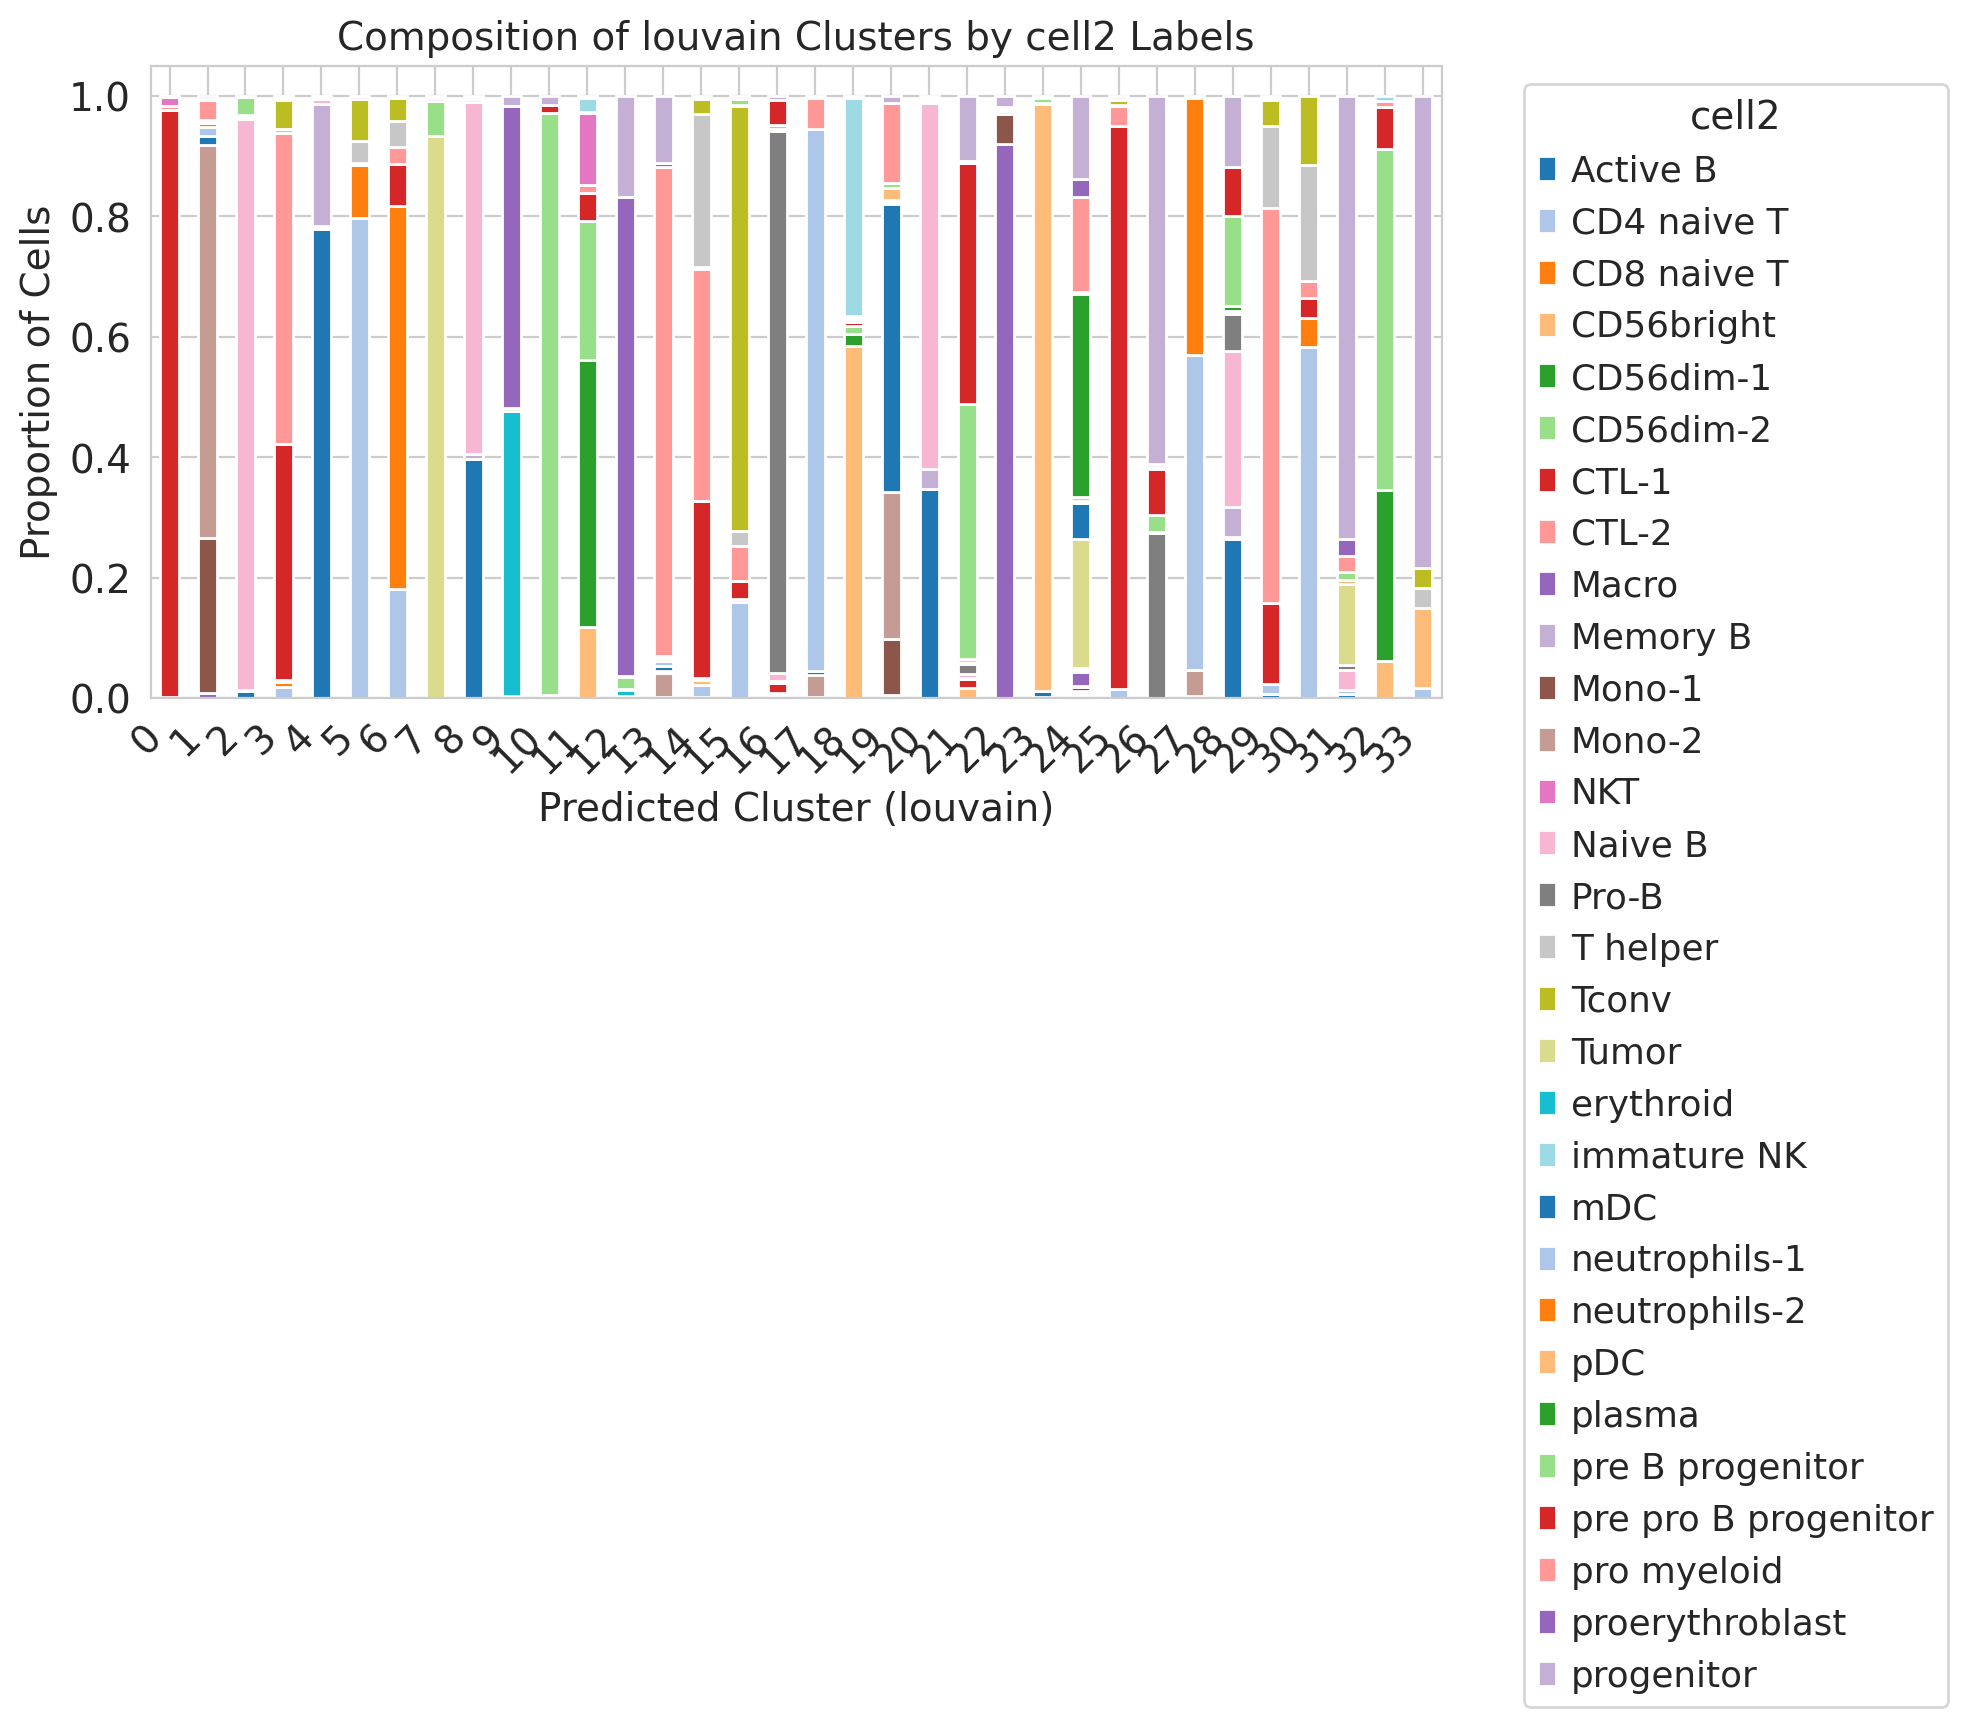


Generating Composition Plot for: leiden



--- 4. GMM Entropy Distribution per 'cell2' Label ---


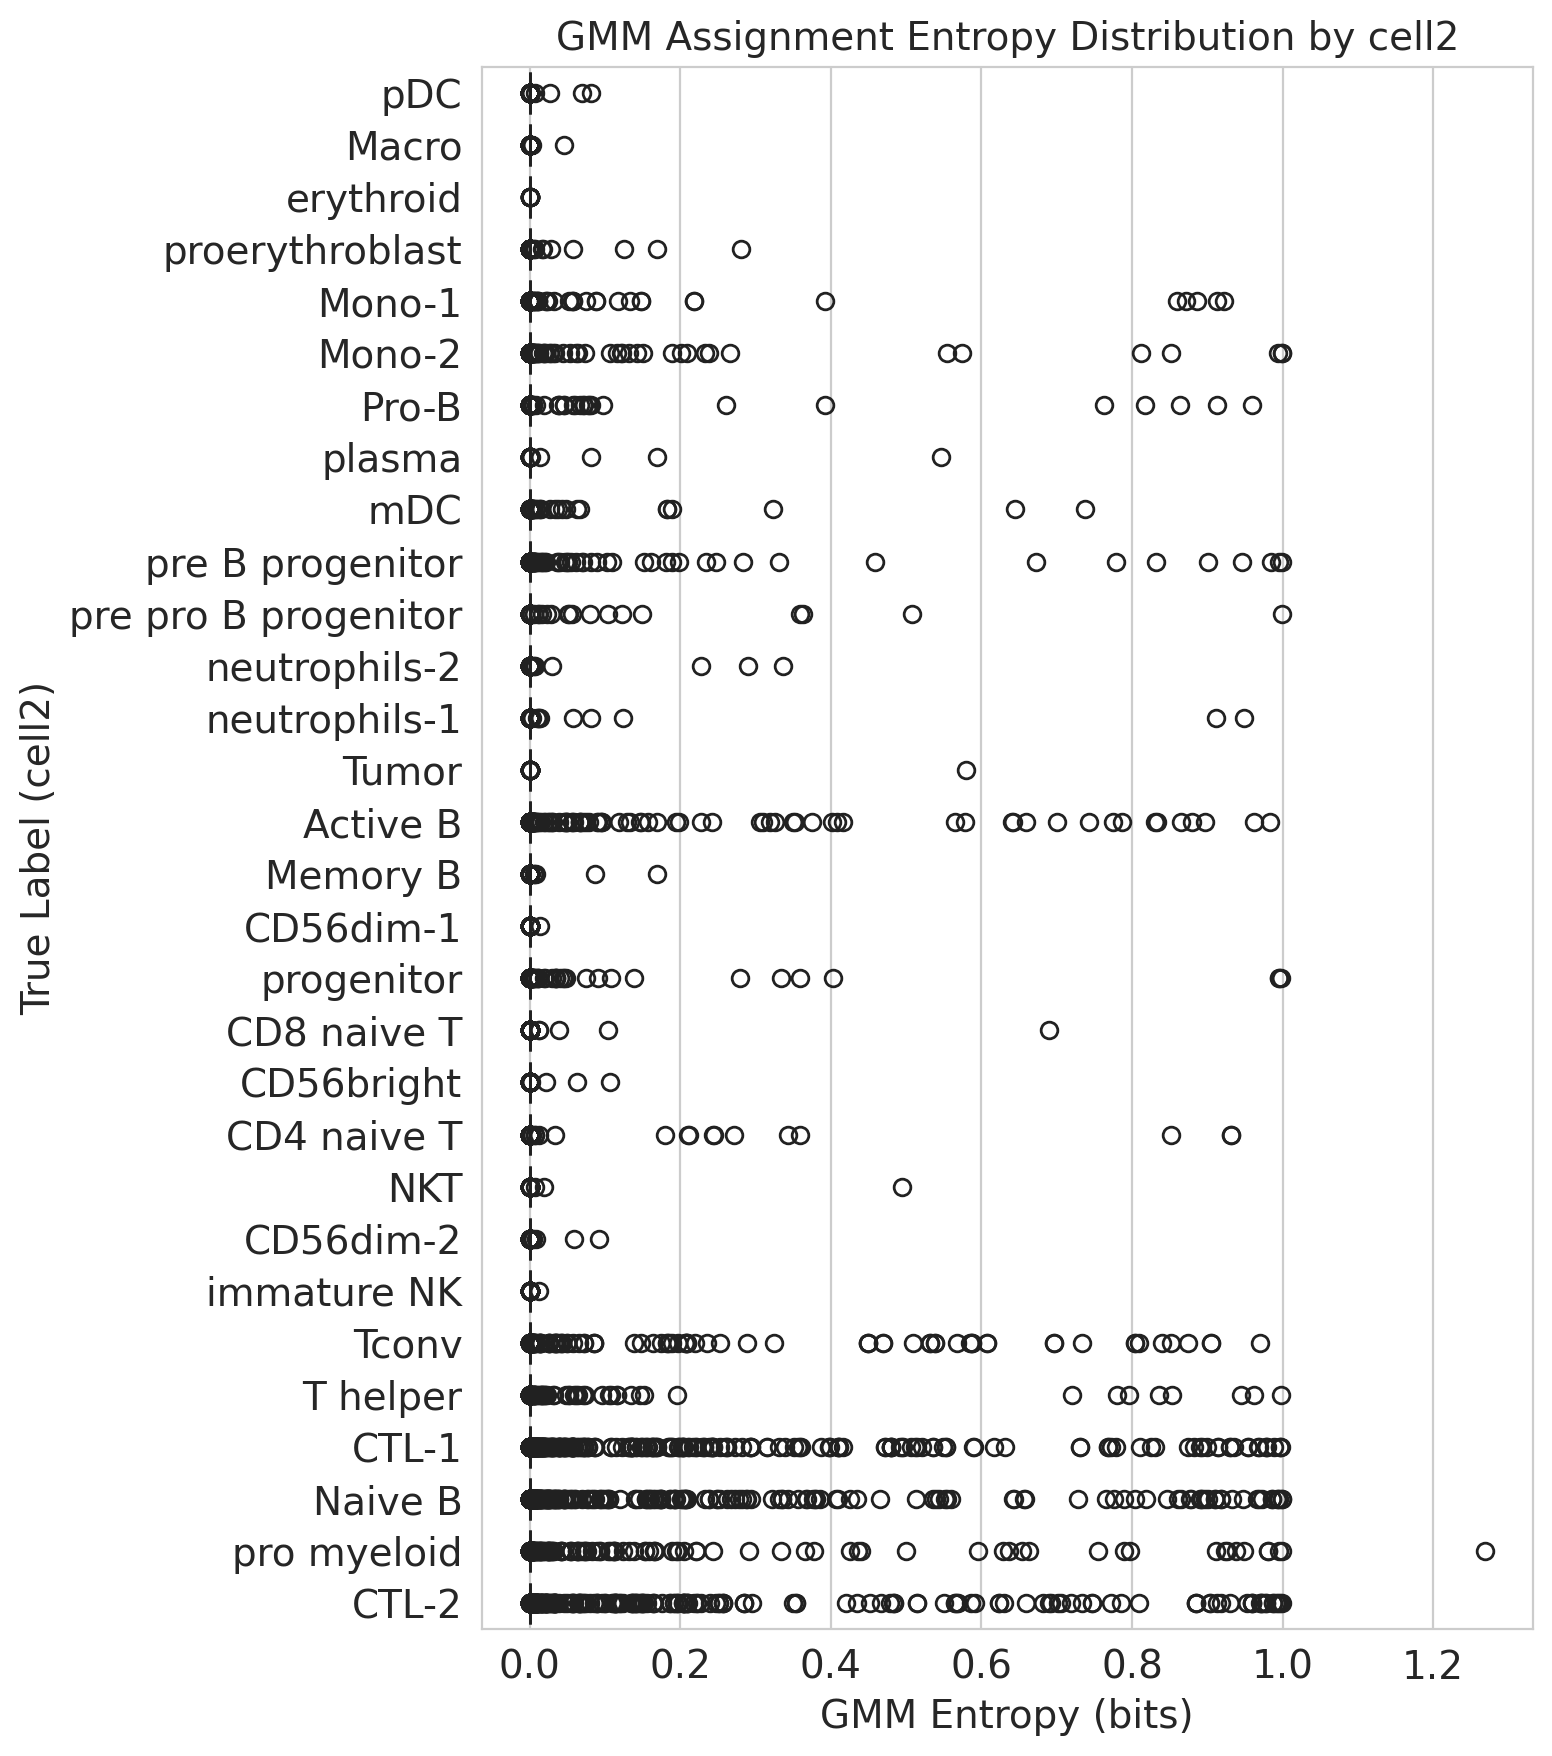


Interpretation Guide (?):
- Higher entropy for a cell indicates it has similar probabilities of belonging to multiple GMM clusters (more uncertainty/ambiguity).
- Lower entropy indicates the cell is strongly assigned to one GMM cluster.
- Examining entropy distribution within known 'cell2' groups can reveal:
  - Groups with consistently low entropy: Likely well-separated and confidently clustered by GMM.
  - Groups with consistently high entropy: May represent intermediate states, poorly separated populations, or areas where GMM struggles.
  - Groups with wide entropy variance: Might contain subpopulations with different clustering certainties.

--- Evaluation Complete ---



In [16]:
# --- Evaluation Against Known Cell-Identity Labels ---
print("\n" + "="*50)
print("--- Starting Evaluation Against Known Cell Labels ---")
print("="*50 + "\n")

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import (
    adjusted_rand_score,
    normalized_mutual_info_score,
    homogeneity_score,
    completeness_score,
    v_measure_score,
    confusion_matrix
)
# --- Configuration ---
# Choose the ground truth label column from embed_adata.obs
# 'cell1' (coarser) or 'cell2' (finer) are good candidates based on the data exploration cell

# Choose the clustering results columns from embed_adata.obs to evaluate
# The notebook previously added: 'GMM_cluster', 'kmeans', 'louvain', 'leiden'
clustering_keys = ['GMM_cluster', 'kmeans', 'louvain', 'leiden']

print(data.obs.columns)

# --- Check if keys exist ---
if ground_truth_key not in data.obs.columns:
    raise KeyError(f"Ground truth key '{ground_truth_key}' not found in embed_adata.obs. Available keys: {list(data.obs.columns)}")

valid_clustering_keys = []
for key in clustering_keys:
    if key in data.obs.columns:
        valid_clustering_keys.append(key)
    else:
        print(f"Warning: Clustering key '{key}' not found in embed_adata.obs. Skipping evaluation for this key.")
clustering_keys = valid_clustering_keys

if not clustering_keys:
    print("No valid clustering keys found to evaluate. Exiting evaluation section.")
else:

    true_labels = data.obs[ground_truth_key]

    # --- 1. Calculate and Print Metrics ---
    print(f"\n--- 1. Clustering Evaluation Metrics (vs '{ground_truth_key}') ---")
    metrics_results = {}
    for key in clustering_keys:
        print(f"\nEvaluating: {key}")
        predicted_labels = data.obs[key]

        ari = adjusted_rand_score(true_labels, predicted_labels)
        nmi = normalized_mutual_info_score(true_labels, predicted_labels)
        homogeneity = homogeneity_score(true_labels, predicted_labels)
        completeness = completeness_score(true_labels, predicted_labels)
        v_measure = v_measure_score(true_labels, predicted_labels)

        metrics_results[key] = {
            'ARI': ari,
            'NMI': nmi,
            'Homogeneity': homogeneity,
            'Completeness': completeness,
            'V-Measure': v_measure
        }
        print(f"  Adjusted Rand Index (ARI): {ari:.4f}")
        print(f"  Normalized Mutual Info (NMI): {nmi:.4f}")
        print(f"  Homogeneity: {homogeneity:.4f}")
        print(f"  Completeness: {completeness:.4f}")
        print(f"  V-Measure: {v_measure:.4f}")

    # Display metrics as a DataFrame
    metrics_df = pd.DataFrame(metrics_results).T
    print("\n--- Metrics Summary ---")
    print(metrics_df)
    print("-" * 25)

     # --- 2. Generate Confusion Matrices ---
    print(f"\n--- 2. Confusion Matrices (True Labels vs Predicted Clusters) ---")
    # Ensure true labels are categorical for proper ordering if they aren't already
    if not isinstance(true_labels, pd.CategoricalDtype):
        true_labels = true_labels.astype('category')
    true_label_names = true_labels.cat.categories

    for key in clustering_keys:
        print(f"\nGenerating Confusion Matrix for: {key}")
        predicted_labels = data.obs[key]

        if not isinstance(predicted_labels.dtype, pd.CategoricalDtype):
            predicted_labels = predicted_labels.astype('category')
        predicted_label_names = predicted_labels.cat.categories

        # Create confusion matrix dataframe using crosstab for correct labeling
        cm_df = pd.crosstab(true_labels, predicted_labels, rownames=[f'True ({ground_truth_key})'], colnames=[f'Predicted ({key})'])
        # Reindex to ensure all true labels are present and in consistent order, recheck this
        cm_df = cm_df.reindex(index=true_label_names, columns=predicted_label_names, fill_value=0)

        # Determine figure size dynamically
        fig_width = max(8, len(predicted_label_names) * 0.6)
        fig_height = max(6, len(true_label_names) * 0.4)
        annotation_size = max(6, 14 - max(len(predicted_label_names), len(true_label_names)) // 2) # Dynamically adjust annotation size

        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(
            cm_df,
            annot=True,
            fmt="d", # Format as integer
            cmap="Blues",
            linewidths=.5,
            annot_kws={"size": annotation_size} # Adjust annotation font size here
        )
        plt.title(f'Confusion Matrix: {key} vs {ground_truth_key}')
        # Labels are now set by crosstab rownames/colnames
        # plt.ylabel(f'True Labels ({ground_truth_key})') # No longer needed
        # plt.xlabel(f'Predicted Clusters ({key})') # No longer needed
        plt.xticks(rotation=90)
        plt.yticks(rotation=0)
        plt.tight_layout()
    plt.show()


    # --- 3. Generate Stacked Bar Plots for Cluster Composition ---
    print(f"\n--- 3. Cluster Composition Bar Plots ---")
    # Using a qualitative colormap suitable for many categories
    try:
        # Try tab20 which has 20 distinct colors, fallback if fewer categories
        colors = plt.get_cmap('tab20').colors
    except ValueError:
        colors = plt.get_cmap('viridis').colors # Fallback

    for key in clustering_keys:
        print(f"\nGenerating Composition Plot for: {key}")
        # Create a cross-tabulation: counts of each true label within each predicted cluster
        ct = pd.crosstab(data.obs[key], data.obs[ground_truth_key])

        # Normalize by cluster (column sum = 1) to show percentage composition
        ct_norm = ct.apply(lambda x: x / x.sum(), axis=1)

        # Plotting
        ax = ct_norm.plot(kind='bar', stacked=True, figsize=(12, 7),
                          color=colors[:len(true_label_names)]) # Use subset of colors
        plt.title(f'Composition of {key} Clusters by {ground_truth_key} Labels')
        plt.xlabel(f'Predicted Cluster ({key})')
        plt.ylabel('Proportion of Cells')
        plt.xticks(rotation=45, ha='right')
        # Place legend outside the plot
        plt.legend(title=ground_truth_key, bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust rect to make space for legend
        # plt.savefig(f'composition_plot_{key}.png', dpi=150, bbox_inches='tight')
        plt.show()


    # --- 4. Examine GMM Entropy Distribution per Known Label ---
    if 'GMM_entropy' in data.obs.columns and 'GMM_cluster' in clustering_keys:
        print(f"\n--- 4. GMM Entropy Distribution per '{ground_truth_key}' Label ---")

        # Create a DataFrame for easier plotting with seaborn
        entropy_df = data.obs[[ground_truth_key, 'GMM_entropy']].copy()

        # Calculate median entropy for sorting categories
        median_entropy = entropy_df.groupby(ground_truth_key)['GMM_entropy'].median().sort_values()
        ordered_labels = median_entropy.index

        plt.figure(figsize=(8, max(5, len(ordered_labels) * 0.3))) # Adjust height based on number of labels
        sns.boxplot(data=entropy_df, y=ground_truth_key, x='GMM_entropy', order=ordered_labels, palette='viridis')
        plt.title(f'GMM Assignment Entropy Distribution by {ground_truth_key}')
        plt.xlabel('GMM Entropy (bits)')
        plt.ylabel(f'True Label ({ground_truth_key})')
        plt.tight_layout()
        # plt.savefig(f'gmm_entropy_by_{ground_truth_key}.png', dpi=150, bbox_inches='tight') 
        plt.show()

        print("\nInterpretation Guide (?):")
        print(f"- Higher entropy for a cell indicates it has similar probabilities of belonging to multiple GMM clusters (more uncertainty/ambiguity).")
        print(f"- Lower entropy indicates the cell is strongly assigned to one GMM cluster.")
        print(f"- Examining entropy distribution within known '{ground_truth_key}' groups can reveal:")
        print(f"  - Groups with consistently low entropy: Likely well-separated and confidently clustered by GMM.")
        print(f"  - Groups with consistently high entropy: May represent intermediate states, poorly separated populations, or areas where GMM struggles.")
        print(f"  - Groups with wide entropy variance: Might contain subpopulations with different clustering certainties.")
    elif 'GMM_entropy' not in data.obs.columns:
         print(f"\n--- Skipping GMM Entropy analysis: 'GMM_entropy' not found in embed_adata.obs ---")
    else: # GMM_entropy exists but GMM_cluster wasn't evaluated
         print(f"\n--- Skipping GMM Entropy analysis: 'GMM_cluster' was not included in evaluated clustering_keys ---")


print("\n" + "="*50)
print("--- Evaluation Complete ---")
print("="*50 + "\n")